This Notebook produces two catalogs of binary stars from filtering the Value Added Catalog:
* from a cut on the likelihood ratio comparing a constant RV model to a two-body model,
* from a cut on the 1st percentile (over `thejoker` samples) value of the velocity semi-amplitude $K$

In [73]:
import pathlib

import astropy.table as at
from astropy.constants import G
import astropy.table as at
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb

# Project
from hq.config import Config

In [2]:
conf = Config('../../hq-config/config.yml')

In [3]:
meta = at.QTable.read(conf.metadata_file)
allstar = at.QTable.read(
    '/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-synspec.fits', 
    hdu=1
)
meta = at.join(meta, allstar, keys='APOGEE_ID')
meta = at.unique(meta, keys='APOGEE_ID')

# Compute percentiles for all samplings

In [74]:
percentiles_file = pathlib.Path('../../cache/hq/metadata-percentiles.fits')

In [70]:
if not percentiles_file.exists():
    percentiles = [1, 5, 50, 95, 99]
    params = [
        'P', 'e', 'K', 'v0', 's',
        'logP', 'logK'
    ]

    percentile_rows = []
    with tb.open_file(conf.joker_results_file, mode='r') as joker_f:
        with tb.open_file(conf.mcmc_results_file, mode='r') as mcmc_f:
            for row in tqdm(meta):
                apid = row['APOGEE_ID']

                if row['mcmc_completed']:
                    f = mcmc_f
                else:
                    f = joker_f

                percentile_row = {
                    'APOGEE_ID': row['APOGEE_ID']
                }
                for par in params:
                    if par.startswith('log'):
                        data = np.log10(np.abs(f.get_node(f'/{apid}/samples').read(field=par[3:])))
                    else:
                        data = f.get_node(f'/{apid}/samples').read(field=par)

                    percentile_row[par] = np.nanpercentile(data, q=percentiles)

                percentile_rows.append(percentile_row)
    
    tbl = at.Table(percentile_rows)
    tbl.write(percentiles_file)
    
else:
    tbl = at.Table.read(percentiles_file)
    
percentiles_tbl = tbl

  0%|          | 0/358350 [00:00<?, ?it/s]

# K cut catalog

Here we make a cut on the 1st percentile sample in log(K):

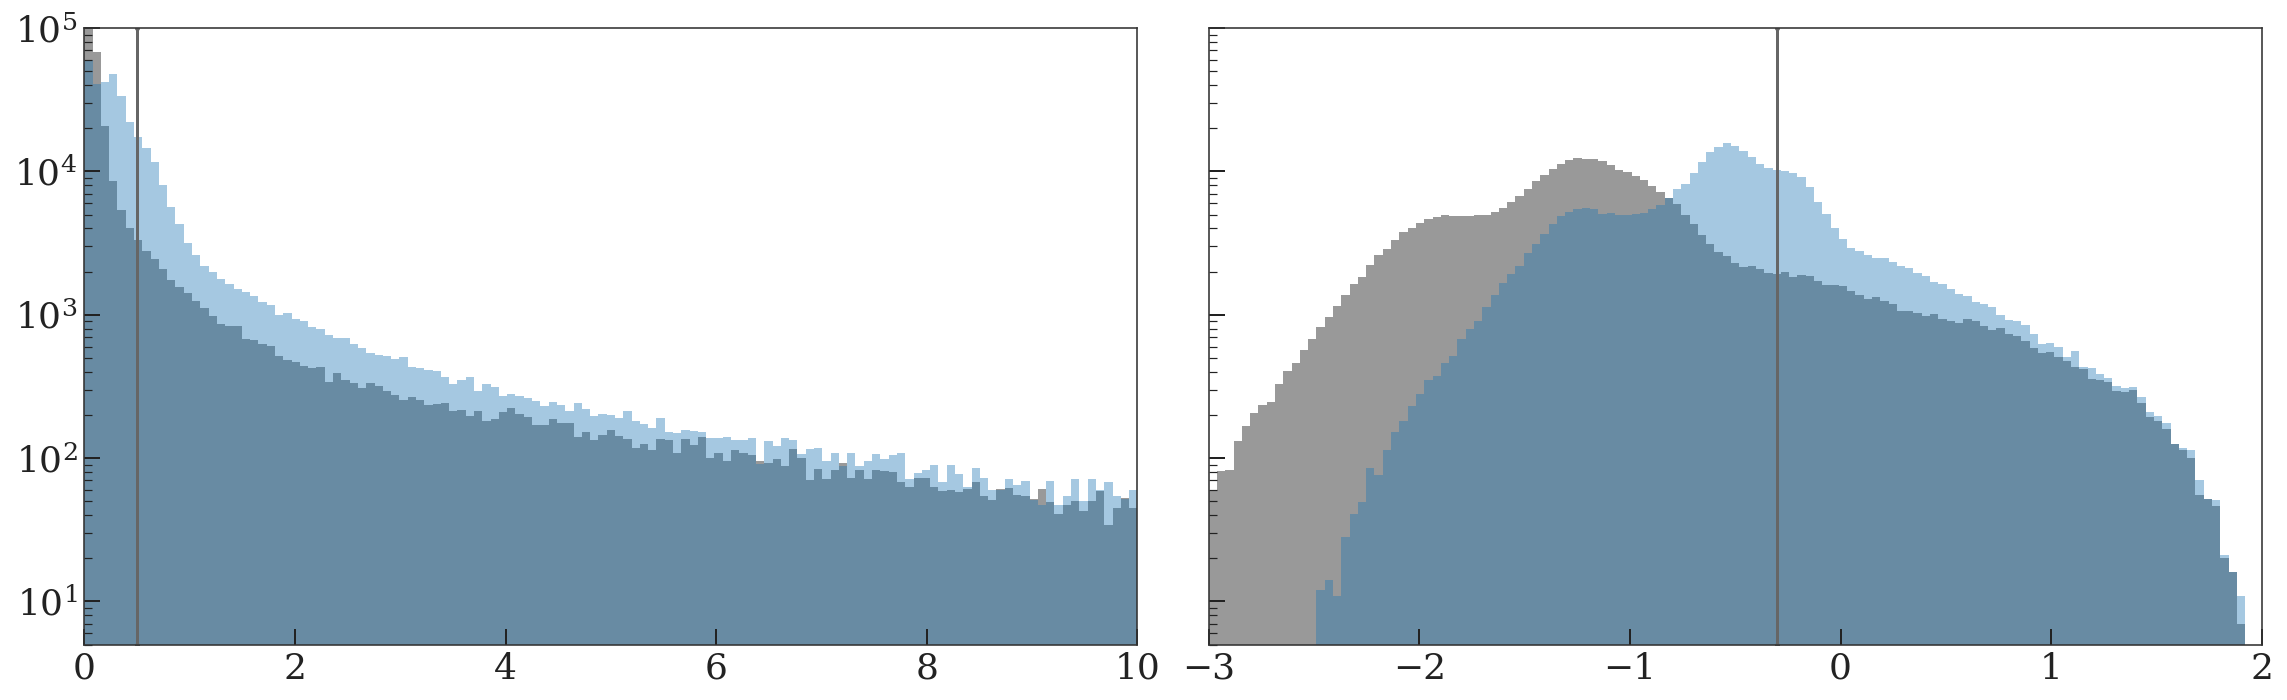

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

ax = axes[0]
bins = np.linspace(0, 10, 128)

for i in range(2):
    ax.hist(percentiles_tbl['K'][:, i], bins=bins, alpha=0.4)

ax.set_yscale('log')
ax.set_xlim(bins.min(), bins.max())
ax.set_ylim(5, 1e5)

ax.axvline(0.5)

ax = axes[1]
bins = np.linspace(-3, 2, 128)
for i in range(2):
    ax.hist(percentiles_tbl['logK'][:, i], bins=bins, alpha=0.4)

ax.set_yscale('log')
ax.set_xlim(bins.min(), bins.max())

ax.axvline(np.log10(0.5))

fig.tight_layout()

In [243]:
lenient_K_cut = 1
lenient_K_percentile_idx = 1
lenient_K_percentile = percentiles[lenient_K_percentile_idx]

strict_K_cut = 1
strict_K_percentile_idx = 0
strict_K_percentile = percentiles[strict_K_percentile_idx]

K_binary_mask_lenient = percentiles_tbl['K'][:, lenient_K_percentile_idx] > lenient_K_cut
K_binary_mask_strict = percentiles_tbl['K'][:, strict_K_percentile_idx] > strict_K_cut
K_binary_mask_lenient.sum(), K_binary_mask_strict.sum()

(48870, 30111)

In [145]:
# row = np.random.choice(meta[K_binary_mask_generous & (percentiles_tbl['K'][:, 1] < 1.5)])
# rvdata = conf.get_source_data(row['APOGEE_ID'])
# _ = rvdata.plot()

# Likelihood ratio

In [189]:
llr_const = meta['max_unmarginalized_ln_likelihood'] - meta['robust_constant_ln_likelihood']
llr_linear = meta['max_unmarginalized_ln_likelihood'] - meta['robust_linear_ln_likelihood']

llr_const = llr_const.filled(np.nan)
llr_linear = llr_linear.filled(np.nan)

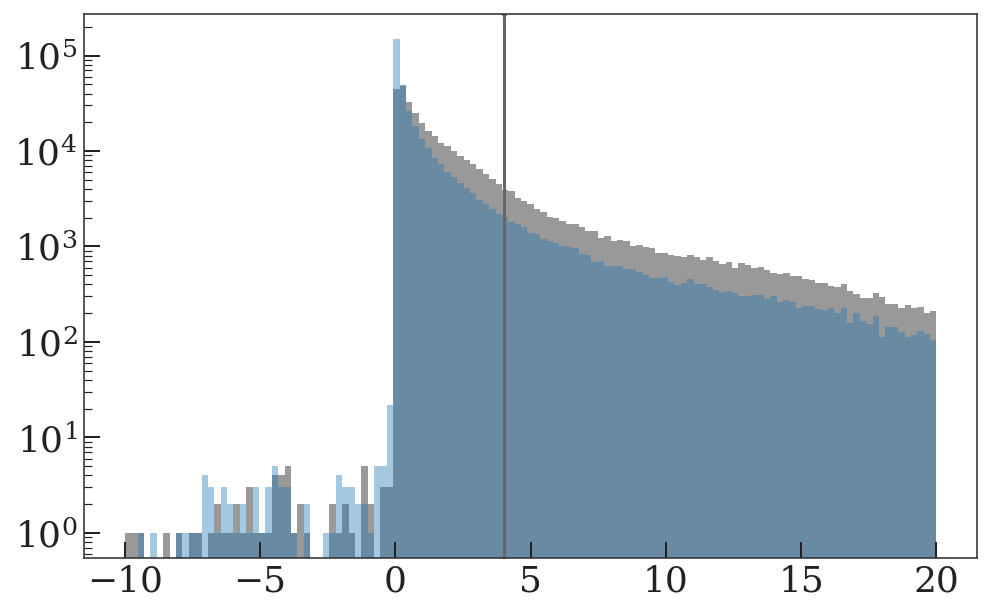

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

bins = np.linspace(-10, 20, 128)
ax.hist(llr_const, bins=bins, alpha=0.4)
ax.hist(llr_linear, bins=bins, alpha=0.4)

ax.set_yscale('log')

ax.axvline(4)

In [234]:
# row = np.random.choice(meta[llr_const_mask & (llr_const < 4.5)])
# # row = np.random.choice(meta[llr_linear_mask & (llr_linear < 6.5)])
# rvdata = conf.get_source_data(row['APOGEE_ID'])
# _ = rvdata.plot()

# Final catalogs: Strict and Lenient

In [239]:
mask_strict = K_binary_mask_strict & (llr_const > 8)
mask_lenient = K_binary_mask_lenient & (llr_const > 4)

plot_mask_lenient = mask_lenient & np.logical_not(mask_strict)
mask_strict.sum(), mask_lenient.sum(), plot_mask_lenient.sum()

(26220, 39689, 13469)

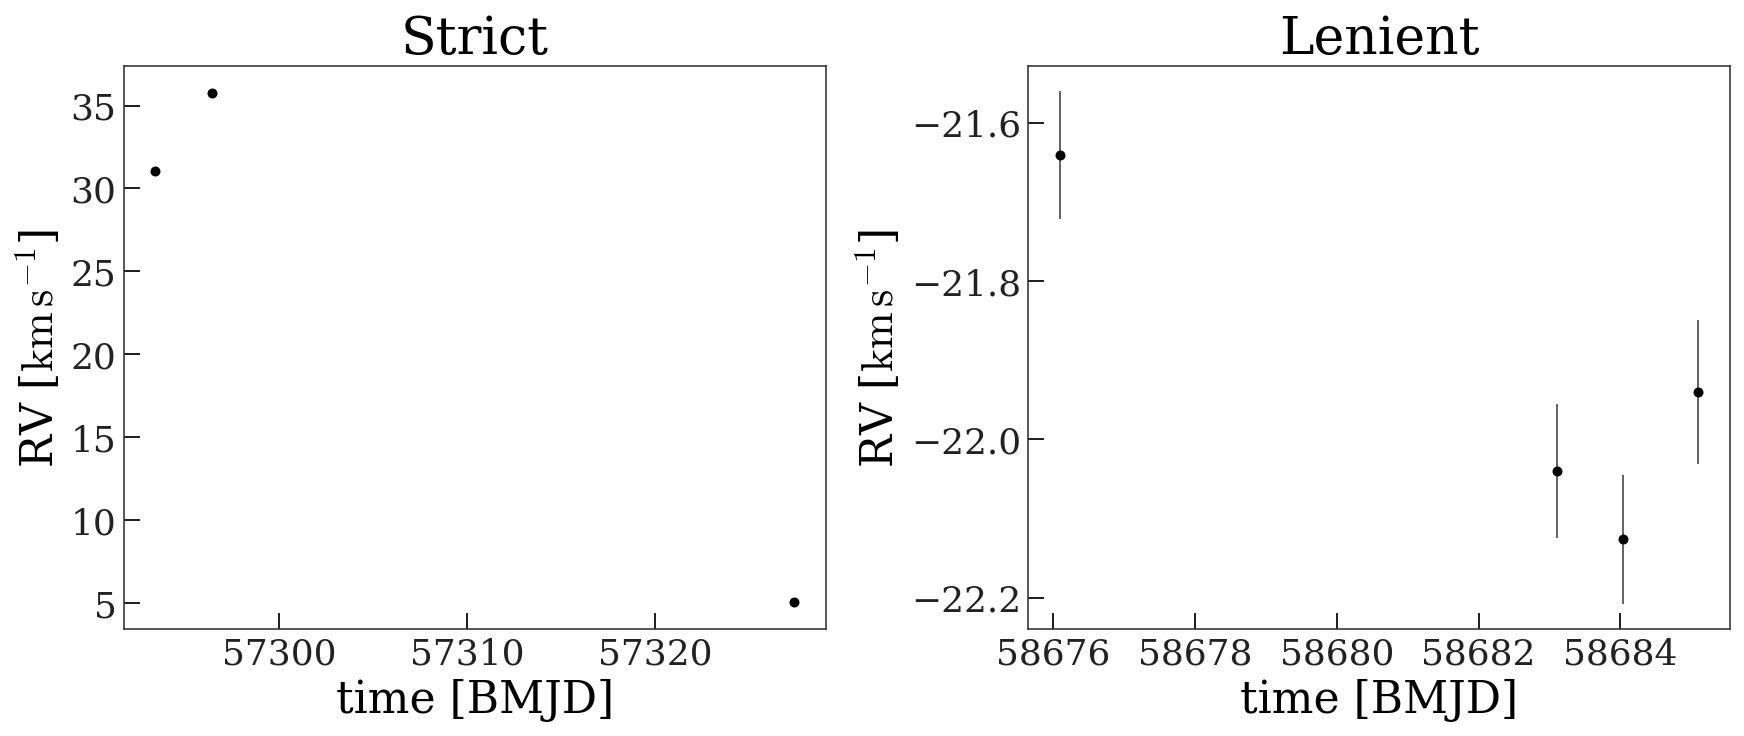

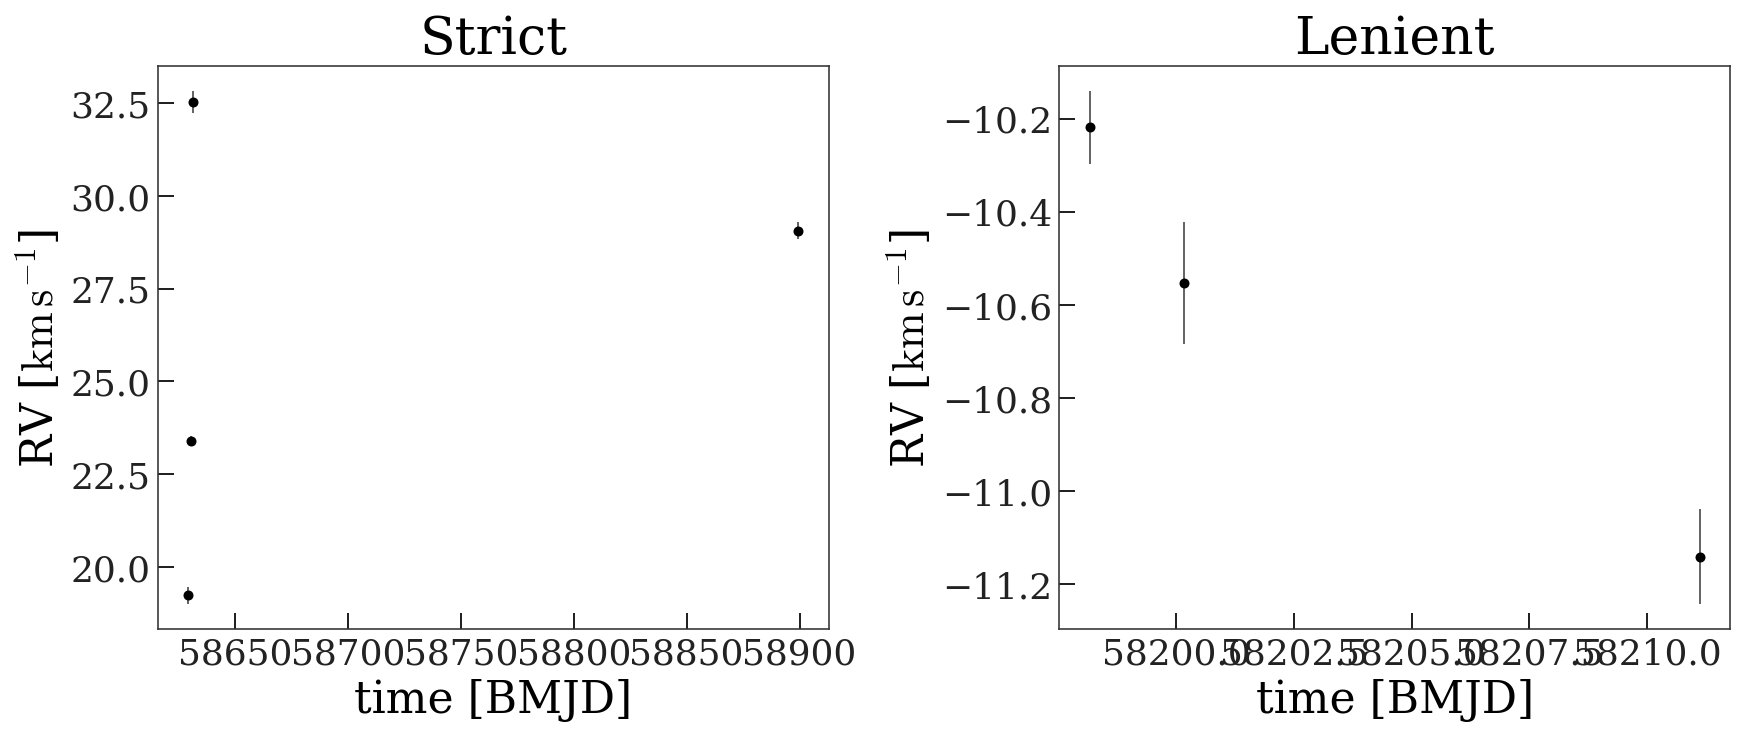

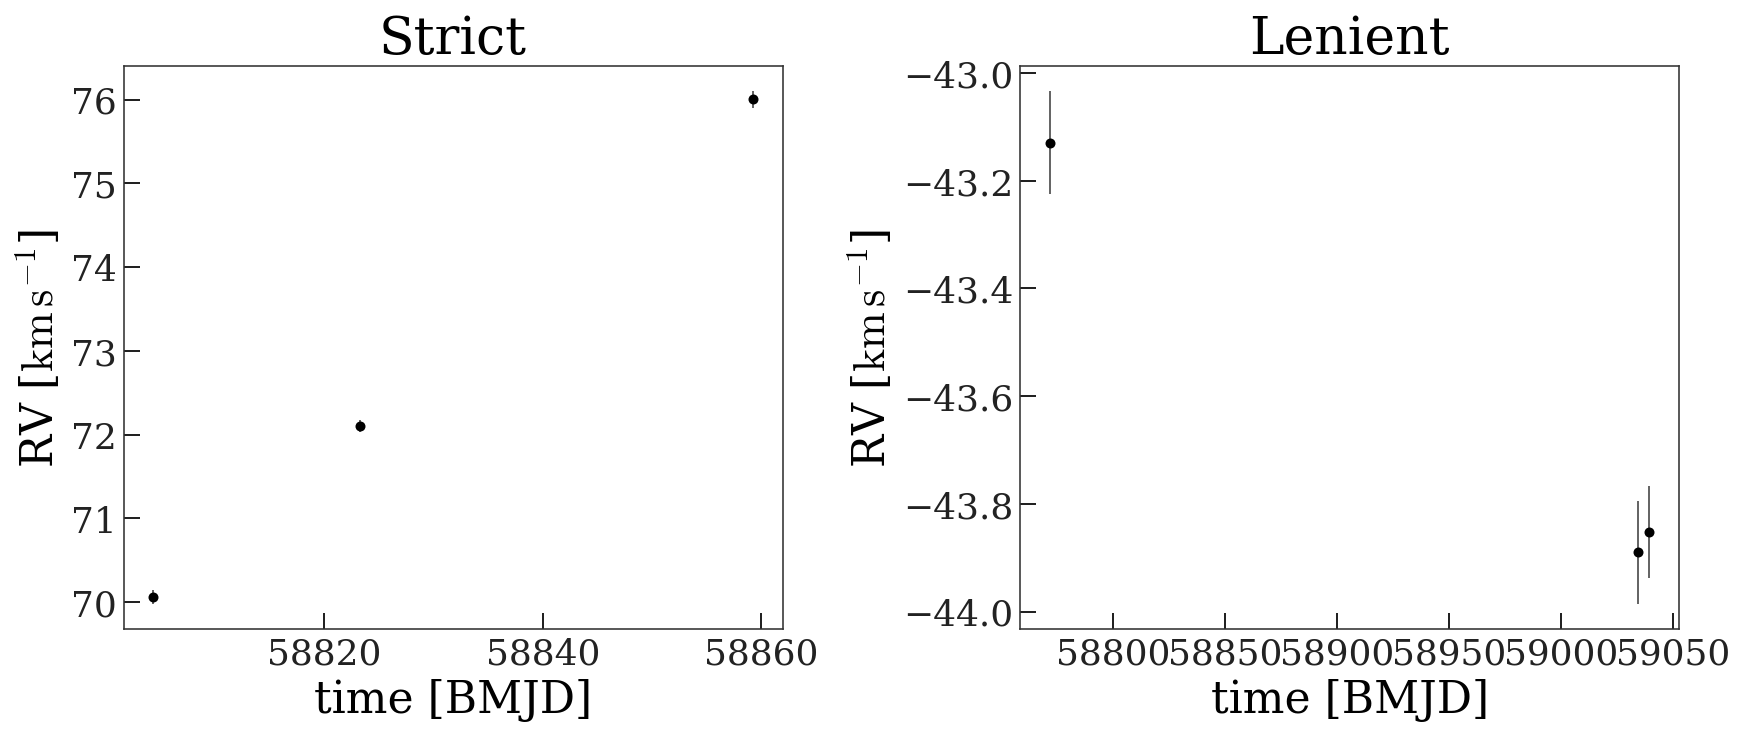

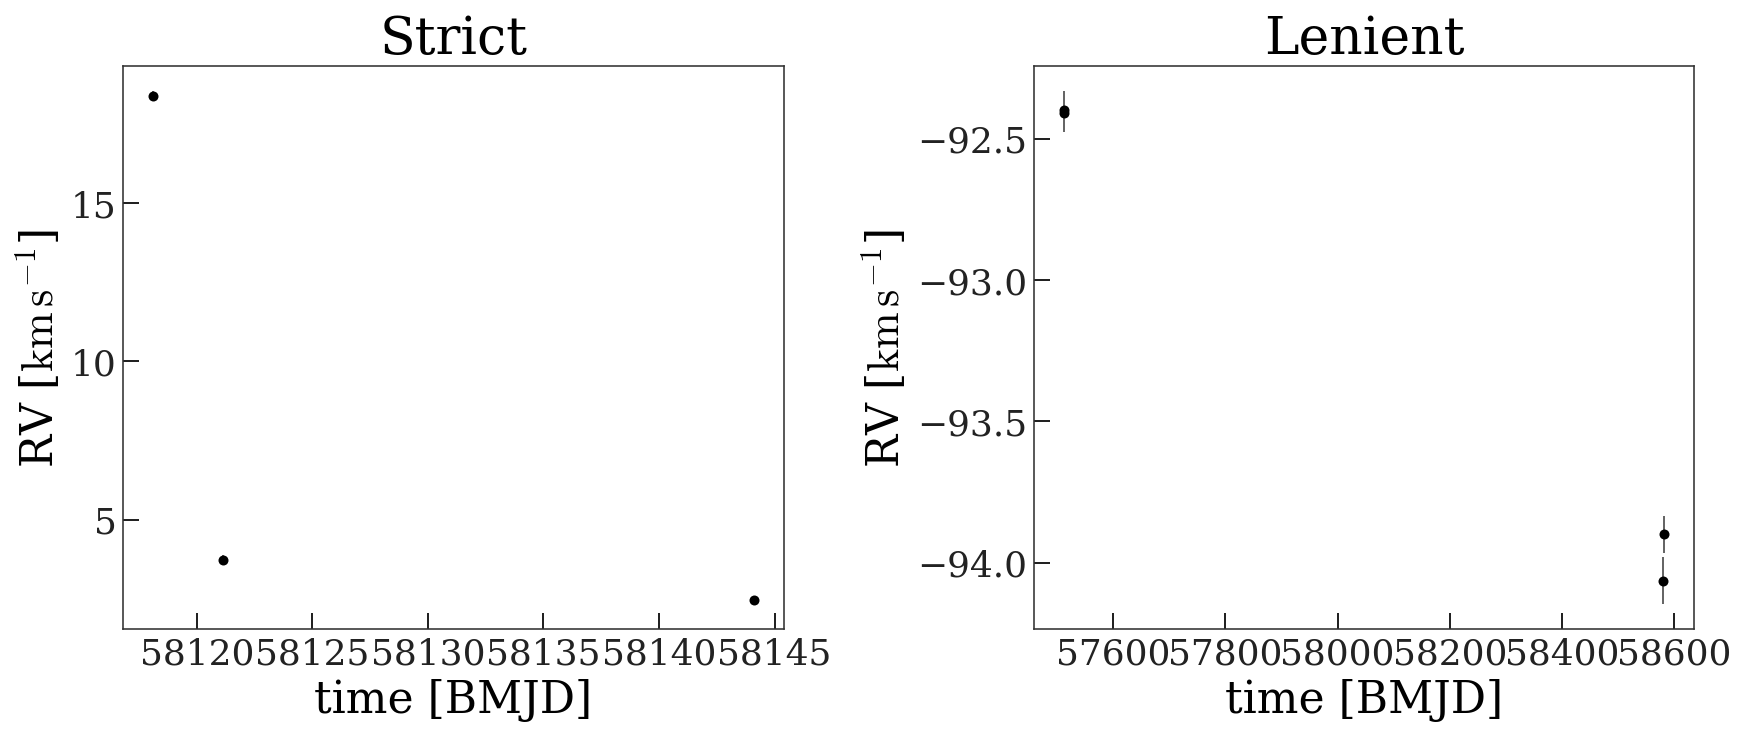

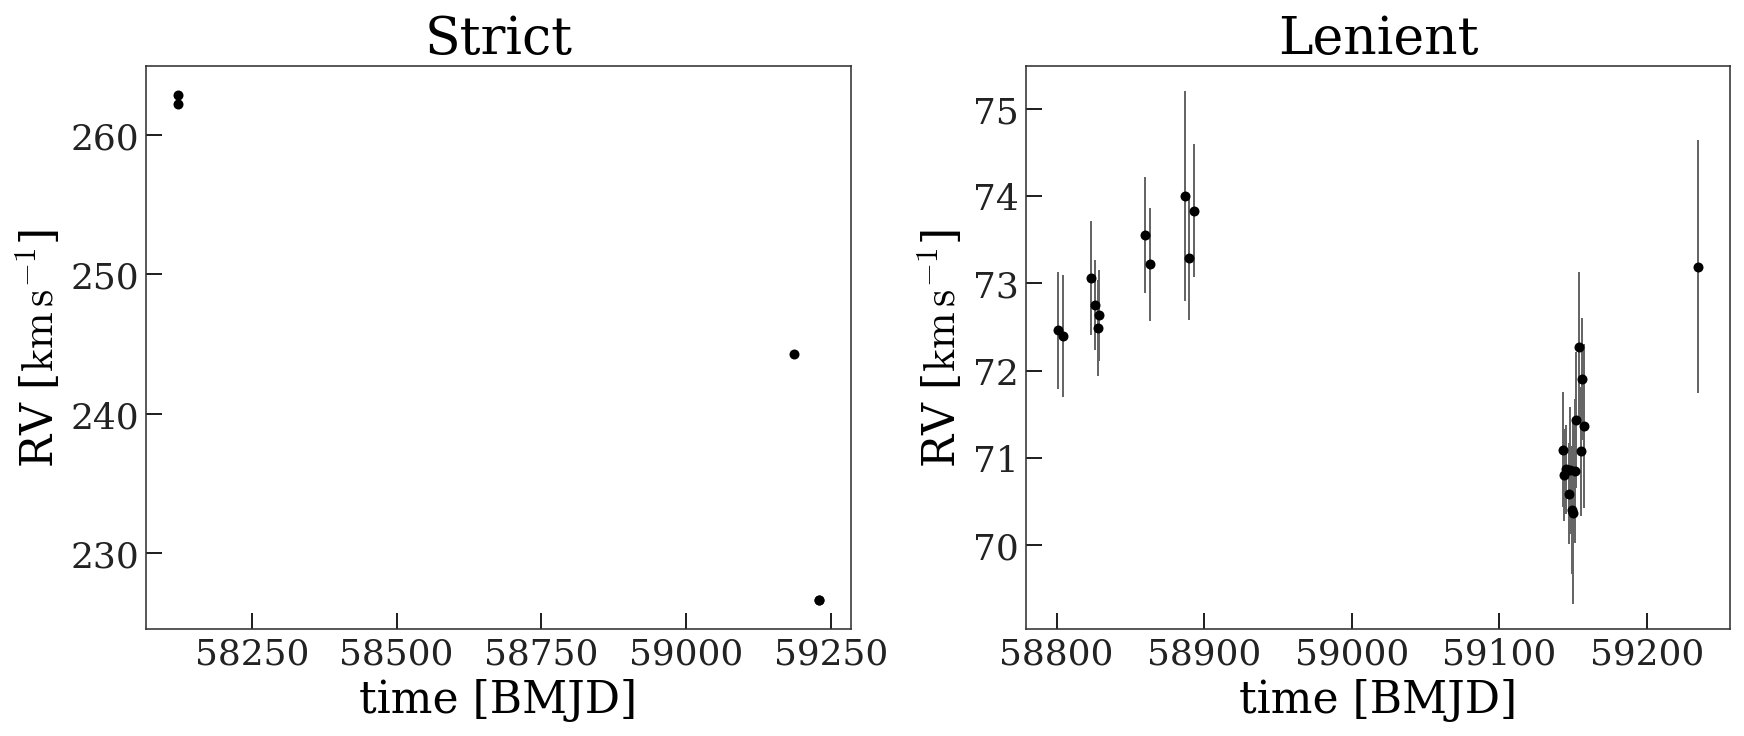

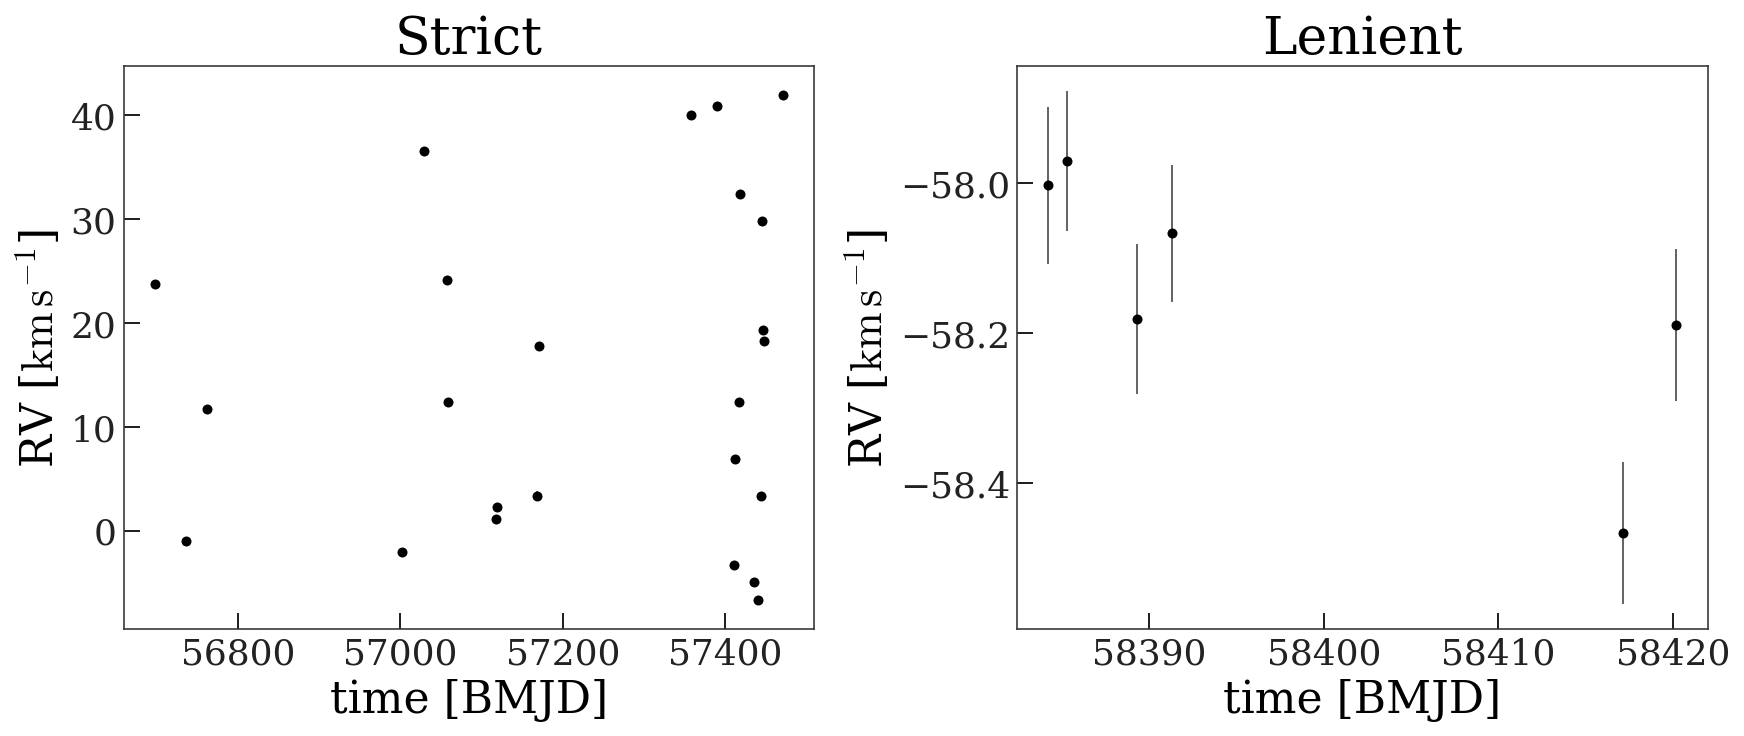

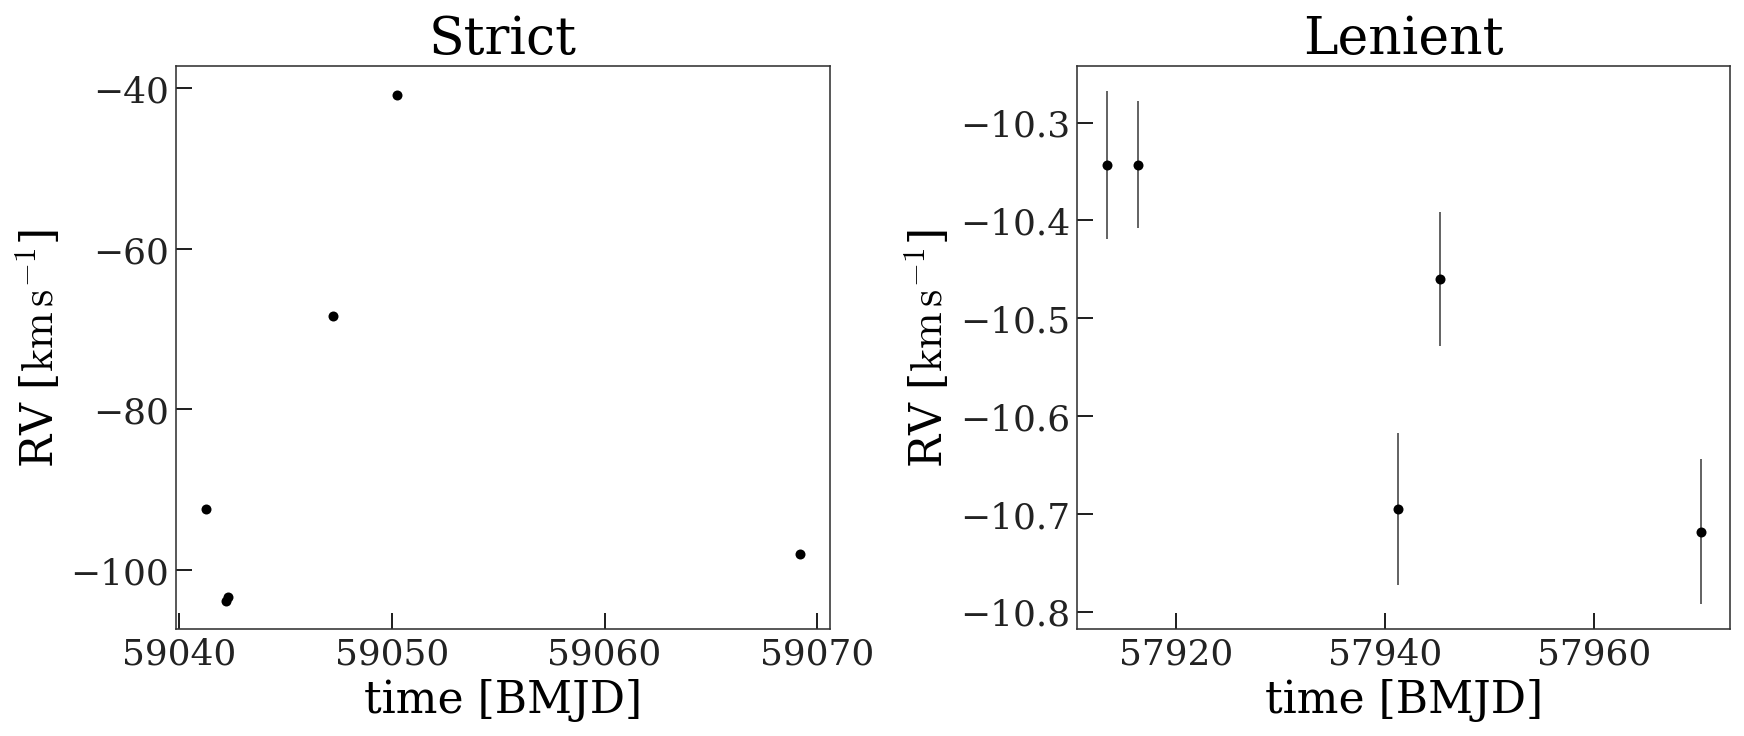

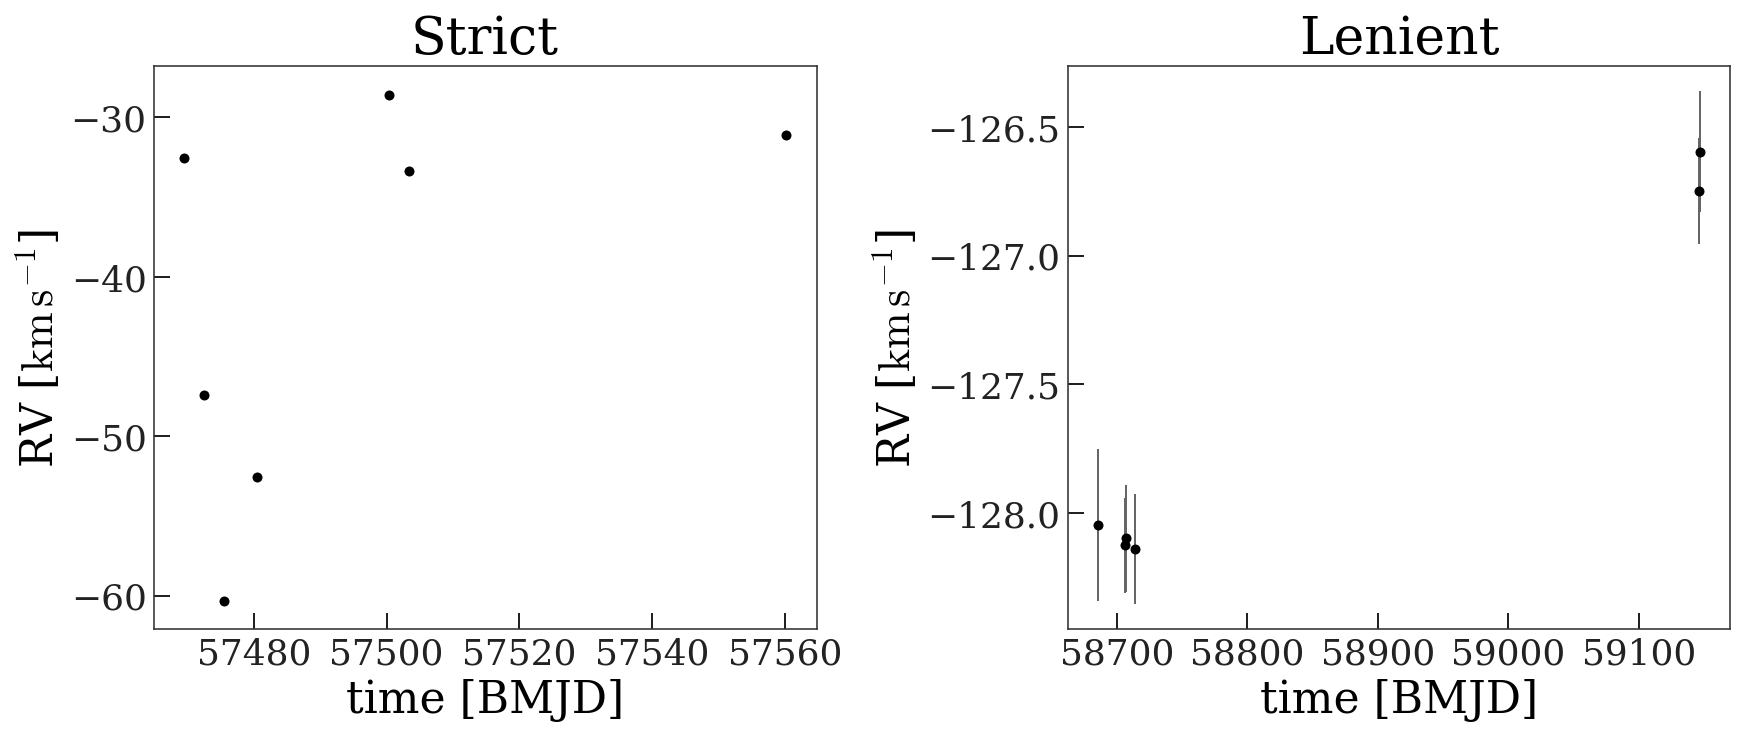

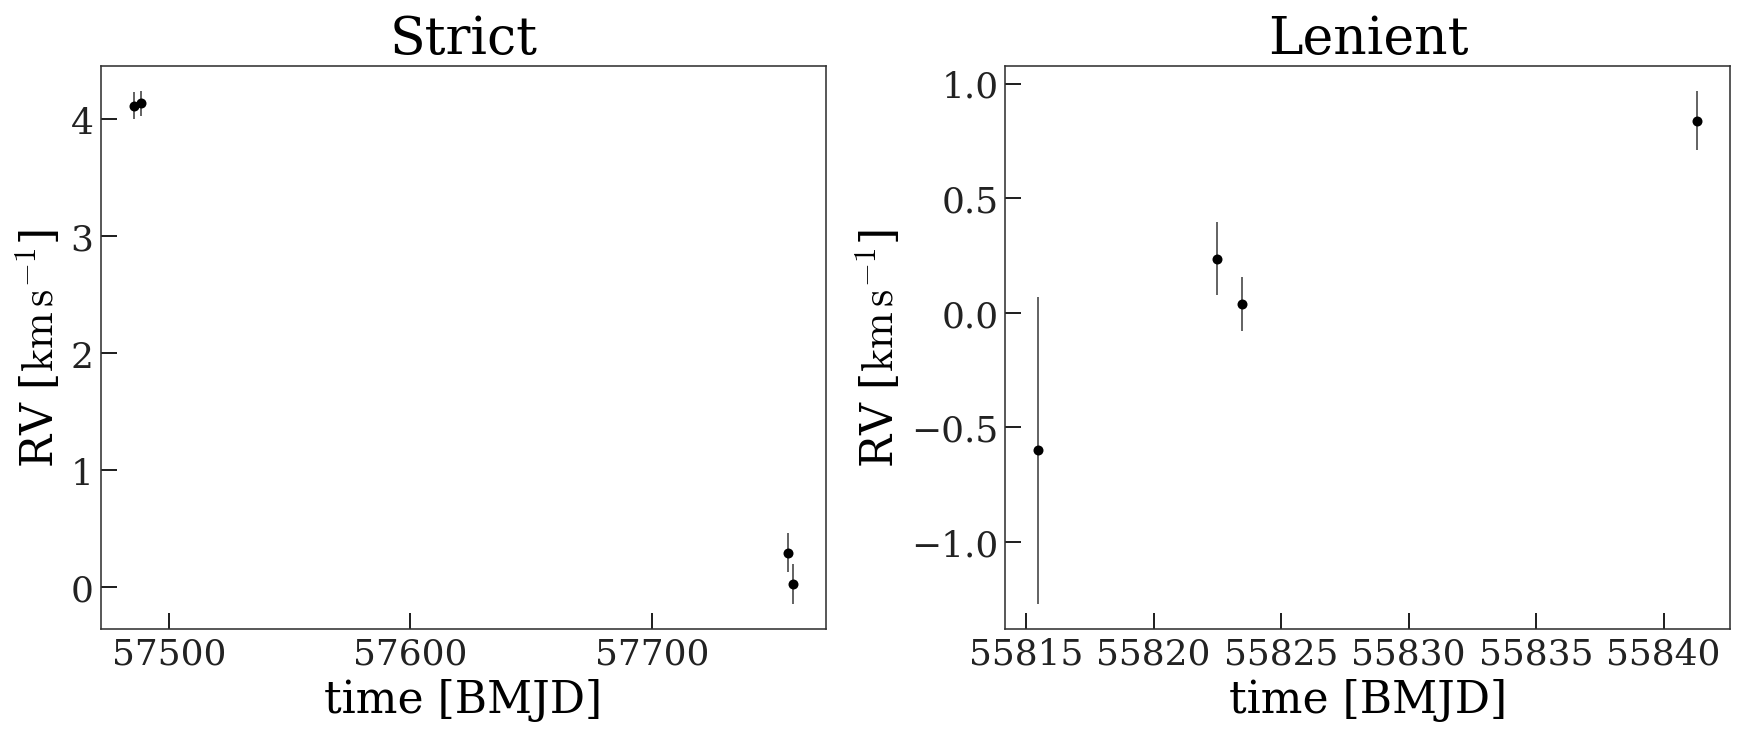

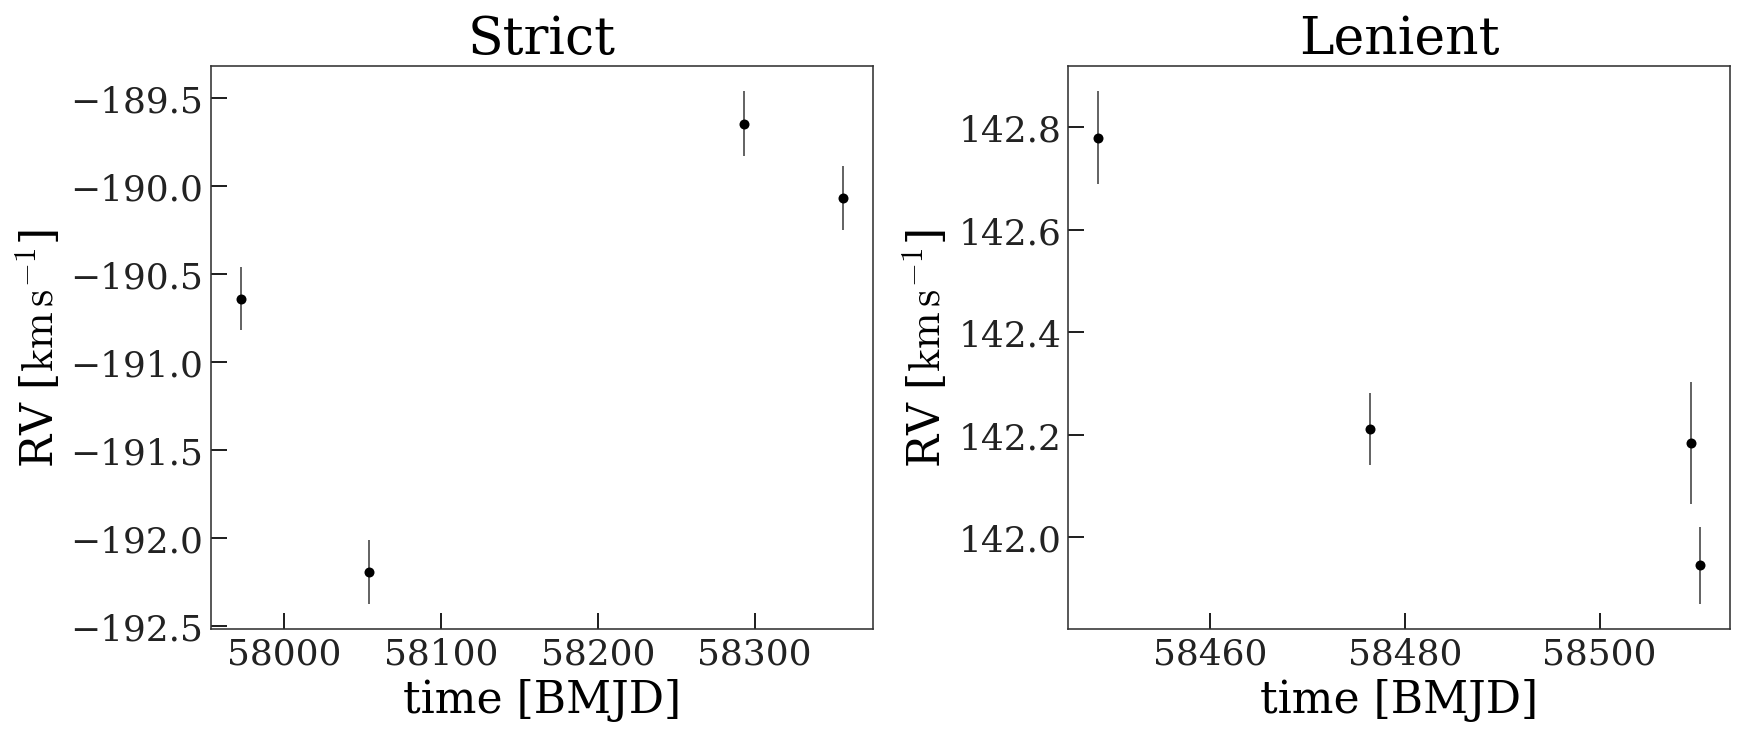

In [240]:
rng = np.random.default_rng(seed=42)

for i in range(10):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), 
                             constrained_layout=True)
    
    row = rng.choice(meta[mask_strict])
    rvdata = conf.get_source_data(row['APOGEE_ID'])
    _ = rvdata.plot(ax=axes[0])
    axes[0].set_title('Strict')
    
    row = rng.choice(meta[plot_mask_lenient])
    rvdata = conf.get_source_data(row['APOGEE_ID'])
    _ = rvdata.plot(ax=axes[1])
    axes[1].set_title('Lenient')

In [250]:
binaries_strict = meta[mask_strict]
binaries_strict.meta['K_cut'] = strict_K_cut
binaries_strict.meta['K_cut_percentile'] = strict_K_percentile
binaries_strict.write('../../catalogs/binaries-strict.fits', overwrite=True)

In [251]:
binaries_lenient = meta[mask_lenient]
binaries_lenient.meta['K_cut'] = lenient_K_cut
binaries_lenient.meta['K_cut_percentile'] = lenient_K_percentile
binaries_lenient.write('../../catalogs/binaries-lenient.fits', overwrite=True)